In [1]:
import pennylane as qml
import pandas as pd
from qco_level_0 import *
from qco_level_1 import optimization_level_1
from qco_level_2 import optimization_level_2
# from qco_level_3 import *
from qco_spec_table import show_circuit
import seaborn as sns
import matplotlib.pyplot as plt
# import penny_to_graph

In [2]:
[ds] = qml.data.load("ketgpt")

In [3]:
# example
seed = 100
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        # if op.name == 'QubitUnitary':
        #     continue
        qml.apply(op)
    return qml.state()

qnode_q1, df = optimization_level_1(circuit)
qnode_q2 = optimization_level_2(qnode_q1)
qnode_q1, df = optimization_level_1(qnode_q2)
# show_circuit(qnode_q1)
df

,original,qiskit,penny,mine
qubits,5,5,5,5
gates,15,15,16,15
1q gates,10,10,10,10
2q gates,5,5,5,5
unitary,0,0,0,0
depth,9,9,10,9


In [4]:
dfs = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            # if op.name == 'QubitUnitary':
            #     continue
            qml.apply(op)
        return qml.state()
    obj = qml.specs(circuit)()['resources']
    try:
        qnode_q1, df= optimization_level_1(circuit)
        qnode_q2 = optimization_level_2(qnode_q1)
        qnode_q1, df = optimization_level_1(qnode_q2)
        dfs.append(df)
    except:
        pass

c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\autoray\autoray.py:81: RuntimeWarning: invalid value encountered in arccos
  return func(*args, **kwargs)
c:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\autoray\autoray.py:81: RuntimeWarning: invalid value encountered in arccos
  return func(*args, **kwargs)
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-276 using the statevector simulator. Required memory: 262144M, max memory: 64690M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-277 using the statevector simulator. Required memory: 8388608M, max memory: 64690M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-278 using the statevector simulator. Required memory: 17592186044416M, max memory: 64690M
Simulatio

In [5]:
len(dfs)                                    

365

In [6]:
dfs[0]

,original,qiskit,penny,mine
qubits,13,13,13,13
gates,162,162,157,158
1q gates,79,79,73,75
2q gates,19,19,19,19
unitary,64,64,64,64
depth,62,69,60,59


In [7]:
dfs_copy = dfs.copy()
dfs_ratio = []
for idx, df in enumerate(dfs_copy):
    df.drop(['qubits'], axis='index', inplace=True)
    # df.drop(['unitary'], axis='index', inplace=True)
    df = df.rename(columns={'qiskit':'Qiskit', 'penny':'PennyLane', 'mine':'HomoGO'},
                             index={'gates': 'Gate count', 'depth': 'Depth'})
    dfs_ratio.append(df.div(df['original'], axis=0).round(3))

dfs_ratio[0]

,original,Qiskit,PennyLane,HomoGO
Gate count,1.0,1.000,0.969,0.975
1q gates,1.0,1.000,0.924,0.949
2q gates,1.0,1.000,1.000,1.000
unitary,1.0,1.000,1.000,1.000
Depth,1.0,1.113,0.968,0.952


In [8]:
dfs_ratio = [df.drop(columns='original') for df in dfs_ratio]

records = []
for df in dfs_ratio:
    for metric in df.index:
        for method in df.columns:
            records.append({
                'metric': metric,
                'method': method,
                'ratio': df.loc[metric, method]
            })

long_df = pd.DataFrame(records)

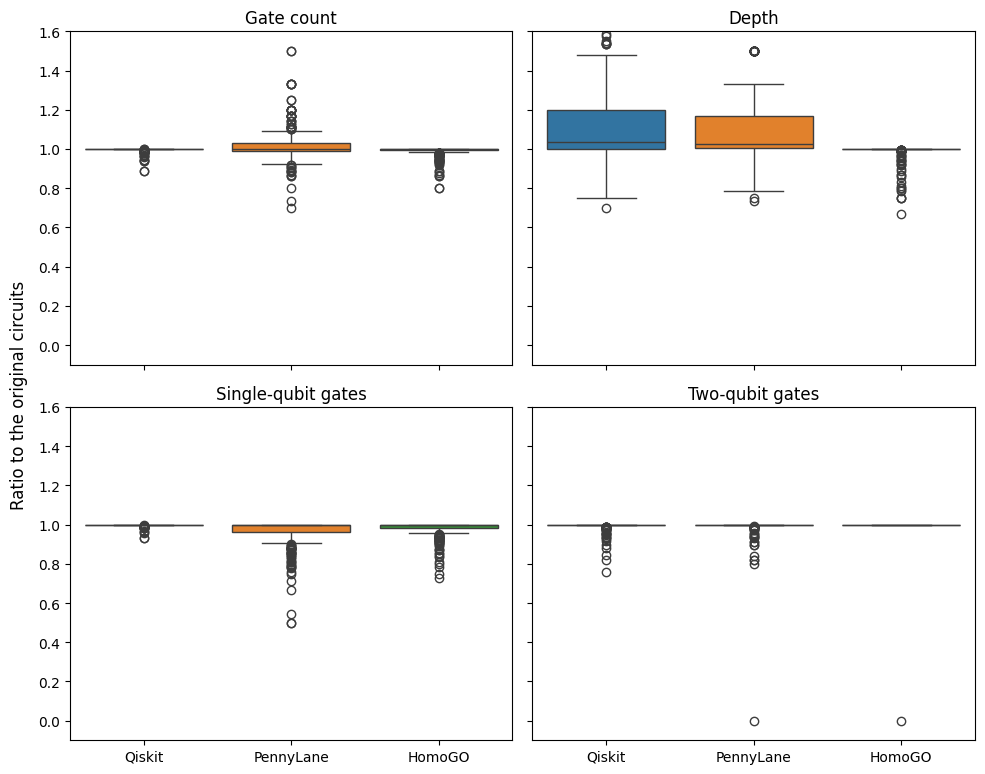

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for i, metric in enumerate(['Gate count', 'Depth', '1q gates', '2q gates']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'HomoGO': '#2ca02c'})
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Depth')
    elif i==2:
        ax.set_title('Single-qubit gates')
    elif i==3:
        ax.set_title('Two-qubit gates')
    ax.set_ylim(-0.1, 1.6)
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('')  # Remove y-axis label
    # ax.set_xticklabels([custom_labels[m] for m in order])

# fig.legend(handles, labels, loc='upper center', ncol=3, title='Method')
fig.supylabel('Ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

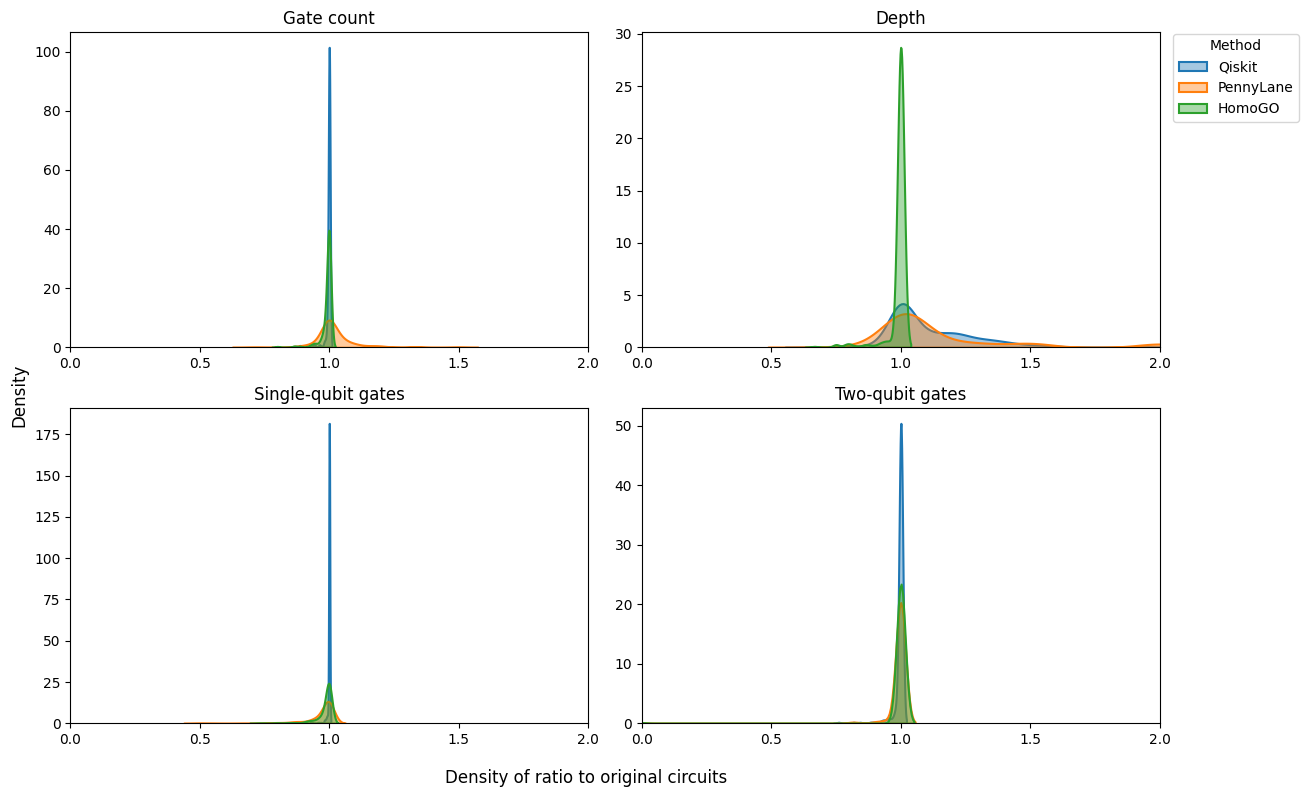

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), ) # sharex=True, sharey=True

palette = {'Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'HomoGO': '#2ca02c'}
methods = long_df['method'].unique()

for i, metric in enumerate(['Gate count', 'Depth', '1q gates', '2q gates']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]

    for method in methods:
        method_data = subset[subset['method'] == method]['ratio']
        sns.kdeplot(method_data, ax=ax, label=method, fill=True, alpha=0.4, linewidth=1.5, color=palette[method])

    titles = ['Gate count', 'Depth', 'Single-qubit gates', 'Two-qubit gates']
    ax.set_title(titles[i])
    ax.set_xlim(0, 2)
    ax.set_xticks(np.arange(0,2.1,0.5))
    ax.set_xlabel('')
    ax.set_ylabel('')           

# Place legend outside the plot (upper right)
fig.legend(
    labels=methods,
    loc='upper right',
    bbox_to_anchor=(1.1, 0.96),
    title='Method'
)

fig.supxlabel('Density of ratio to original circuits')
fig.supylabel('Density')
plt.tight_layout()
plt.show()

In [11]:
long_df.groupby(['method','metric'])['ratio'].agg(['mean']).reset_index()

,method,metric,mean
0,HomoGO,1q gates,0.981726
1,HomoGO,2q gates,0.997041
2,HomoGO,Depth,0.989636
3,HomoGO,Gate count,0.989940
4,HomoGO,unitary,1.000000
5,PennyLane,1q gates,0.966244
6,PennyLane,2q gates,0.991757
7,PennyLane,Depth,1.142512
8,PennyLane,Gate count,1.018953
9,PennyLane,unitary,1.000000


In [12]:
min_df = long_df.groupby(['method','metric'])['ratio'].agg(['mean']).reset_index()
min_df['mean'] = (1-min_df['mean'])*100
min_df

,method,metric,mean
0,HomoGO,1q gates,1.827397
1,HomoGO,2q gates,0.295858
2,HomoGO,Depth,1.036438
3,HomoGO,Gate count,1.006027
4,HomoGO,unitary,0.000000
5,PennyLane,1q gates,3.375616
6,PennyLane,2q gates,0.824260
7,PennyLane,Depth,-14.251233
8,PennyLane,Gate count,-1.895342
9,PennyLane,unitary,0.000000
